# CO2 to Ethanol (fuel)
Ethanol (or the drinkable alcohol) is a part of [ethanol fuel](https://en.wikipedia.org/wiki/Ethanol_fuel) a form of fuel that can be used by a lot of the current cars.
You can use natural sources like different kids of crops but the best part is if we can get this from CO2 to create cycle.
For this will we use the reaction database we loaded into Neo4j

In [1]:
import json
import os
from pathlib import Path
from py2neo import Graph

with open("config.json") as f:
    config = json.load(f)

temp_dir = "temp"
os.makedirs(temp_dir, exist_ok=True)

port = config["port"]
user = config["user"]
pswd = config["pswd"]
neo4j_import_loc = Path(config["neo4j_import_loc"])

graph = Graph("bolt://localhost:" + port, auth=(user, pswd))

If we go for a naif approach we will look how many reactions go directly from CO2 to ethanol. Turns out, zero in our database.

In [2]:
count = graph.run(
    """
        MATCH (co2:Compound {inChI: "InChI=1S/CO2/c2-1-3"})
        MATCH (ethanol:Compound {inChI: "InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3"})
        MATCH (co2)-[:INPUT {role: "REACTANT"}]->(r1)-[:OUTPUT]->(n:Compound)-[:INPUT {role: "REACTANT"}]->(r2)-[:OUTPUT]->(ethanol)
        RETURN count(*) as count
    """
).data()[0]["count"]
print(f"Number of paths between CO2 and ethanol: {count}")

Number of paths between CO2 and ethanol: 0


In [3]:
response = graph.run(
    """
        MATCH (co2:Compound {inChI: "InChI=1S/CO2/c2-1-3"})
        MATCH (ethanol:Compound {inChI: "InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3"})
        MATCH p=shortestPath((co2)-[:INPUT|OUTCOME*]->(ethanol))

        RETURN p
    """
).data()
print(response)

[{'p': Path(Node('Compound', inChI='InChI=1S/CO2/c2-1-3'), INPUT(Node('Compound', inChI='InChI=1S/CO2/c2-1-3'), Node('Reaction', reactionId='ord-5eda1182b1264723b3a894aacf443372'), role='REACTANT'), OUTCOME(Node('Reaction', reactionId='ord-5eda1182b1264723b3a894aacf443372'), Node('Compound', inChI='InChI=1S/C6H14O6/c7-1-3(9)5(11)6(12)4(10)2-8/h3-12H,1-2H2')), INPUT(Node('Compound', inChI='InChI=1S/C6H14O6/c7-1-3(9)5(11)6(12)4(10)2-8/h3-12H,1-2H2'), Node('Reaction', reactionId='ord-e670b25af0e94dada36f72909ecf088a'), role='REACTANT'), OUTCOME(Node('Reaction', reactionId='ord-e670b25af0e94dada36f72909ecf088a'), Node('Compound', inChI='InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3')))}]


In [6]:
reactions = graph.run(
    """
        MATCH (co2:Compound {inChI: "InChI=1S/CO2/c2-1-3"})
        MATCH (ethanol:Compound {inChI: "InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3"})
        MATCH p=shortestPath((co2)-[:INPUT|OUTCOME*]->(ethanol))

        UNWIND nodes(p) as p2
        WITH p2
        WHERE "Reaction" in labels(p2)

        CALL {
            with p2
            MATCH (p2)<-[:INPUT]-(c:Compound)
            RETURN collect(c.inChI) as inputs
        }

        CALL {
            with p2
            MATCH (p2)-[:OUTCOME]->(c:Compound)
            RETURN collect(c.inChI) as outputs
        }

        RETURN p2.reactionId as reactionId, inputs, outputs
    """
).data()
for reaction in reactions:
    print(reaction)

{'reactionId': 'ord-5eda1182b1264723b3a894aacf443372', 'inputs': ['InChI=1S/CO2/c2-1-3', 'InChI=1S/C6H12O6/c7-1-3(9)5(11)6(12)4(10)2-8/h1,3-6,8-12H,2H2', 'InChI=1S/C2H6OS/c1-4(2)3/h1-2H3'], 'outputs': ['InChI=1S/C6H14O6/c7-1-3(9)5(11)6(12)4(10)2-8/h3-12H,1-2H2']}
{'reactionId': 'ord-e670b25af0e94dada36f72909ecf088a', 'inputs': ['InChI=1S/C10H18O/c1-9(2)7-4-5-10(9,3)8(11)6-7/h7-8,11H,4-6H2,1-3H3', 'InChI=1S/C6H14O6/c7-1-3(9)5(11)6(12)4(10)2-8/h3-12H,1-2H2', 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3'], 'outputs': ['InChI=1S/C10H18O/c1-9(2)7-4-5-10(9,3)8(11)6-7/h7-8,11H,4-6H2,1-3H3', 'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3']}


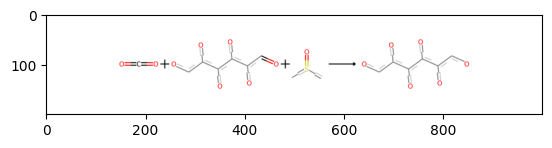

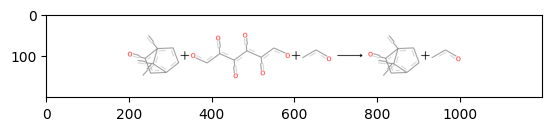

In [15]:
from rdkit import Chem
from rdkit.Chem import Draw
from matplotlib import pyplot

for reaction in reactions:
    inputs_raw = reaction["inputs"]
    outputs_raw = reaction["outputs"]

    inputs = [Chem.MolFromInchi(i) for i in inputs_raw]
    outputs = [Chem.MolFromInchi(i) for i in outputs_raw]

    input1_smiles = ".".join([Chem.MolToSmiles(i) for i in inputs])
    output1_smiles = ".".join([Chem.MolToSmiles(i) for i in outputs])
    reaction = Chem.rdChemReactions.ReactionFromSmarts(
        f"{input1_smiles}>>{output1_smiles}"
    )
    img = Draw.ReactionToImage(reaction)
    pyplot.imshow(img)
    pyplot.show()